# Intro

[Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) is a dataset crafted by Zalando, containing 70,000 gray scale images of different apparel:

| Label | Description |
| --- | --- |
| 0 | T-shirt/top |
| 1 | Trouser |
| 2 | Pullover |
| 3 | Dress |
| 4 | Coat |
| 5 | Sandal |
| 6 | Shirt |
| 7 | Sneaker |
| 8 | Bag |
| 9 | Ankle boot |

Each image is a `28x28`type image, just like the MNIST dataset, Zalando's team [hope to replace](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md#to-serious-machine-learning-researchers) because: 
- MNIST is too easy. (...)
- MNIST is overused. (...)
- MNIST can not represent modern CV tasks (...) 

# Preparation

In [0]:
import pandas as pd

root_path = '/content/drive/notebooks/datasets/'
root_folder = 'zalendo-mnist/'

train_file = 'fashion-mnist_train.csv'
test_file = 'fashion-mnist_test.csv'

train = pd.read_csv(root_path+root_folder+train_file)
test = pd.read_csv(root_path+root_folder+test_file)

The training set is equally distributed over the 10 classes.

In [90]:
train['label'].value_counts()

9    6000
8    6000
7    6000
6    6000
5    6000
4    6000
3    6000
2    6000
1    6000
0    6000
Name: label, dtype: int64

Let's define some helper functions for visualization.

In [0]:
image_slice = slice(1,None)
image_dims = (28, 28)
input_size = image_dims+(1,)

classes = ['T-shirt/top',
        'Trouser',
        'Pullover',
        'Dress',
        'Coat',
        'Sandal',
        'Shirt',
        'Sneaker',
        'Bag',
        'Ankle boot']

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import random

def plot_image(image, title=None):
  plt.axis('off')
  plt.imshow(image, interpolation='nearest')
  if(title is not None):
    plt.title(title)

def get_class_name(logit, classes=classes):
  if(logit < len(classes) and logit >= 0):
    return classes[logit]
  else:
    return 'Unknown'
  
def get_image(df, index=None, 
              image_slice=image_slice, 
              image_dimensions=image_dims):
  if(index is None):
    index = random.randint(0, len(df))
  image = df.iloc[index,image_slice]
  return np.resize(image, image_dimensions), df.iloc[index, 0]

def plot_random_samples(df, grid_shape=(8,8),
                     plot=plot_image, 
                     get_image=get_image,
                     get_class_name=get_class_name):
  plt.figure(figsize=(8,10))
  for index in range(grid_shape[0] * grid_shape[1]):
    plt.subplot(grid_shape[0], grid_shape[1], index + 1)
    image, label = get_image(df)
    plot(image, get_class_name(label))

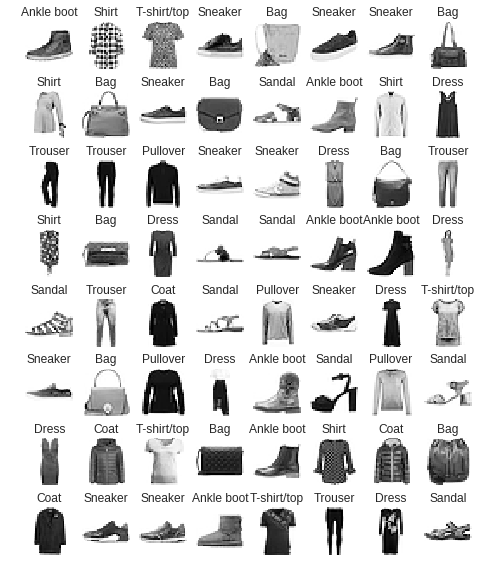

In [12]:
plot_random_samples(train)

Since the data is equally distributed between class we don't need to handle data imbalance in the train, validation and test split.

We also need to resize our flat images into `(28,28,1)` matrices, normalize them and convert our labels in a hot encoding manner.

In [13]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

def process_labels(df, label_index=0):
  return to_categorical(np.array(df.iloc[:,label_index]))

def prepare_image_feature(df, image_slice=image_slice):
  return np.array(df.iloc[:, image_slice])

def reshape_normalize_image(X, image_shape=image_dims):
  return (X.reshape(len(X), image_shape[0], image_shape[1], 1).astype('float32')) / 255

y = process_labels(train)
X = prepare_image_feature(train)
X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                    stratify=y, 
                                                    test_size=0.10, 
                                                    random_state=4422)

y_test = process_labels(test)
X_test = prepare_image_feature(test)

X_train = reshape_normalize_image(X_train)
X_test = reshape_normalize_image(X_test)
X_val = reshape_normalize_image(X_val)


Using TensorFlow backend.


# Data Augmentation

Data augmentation in Keras is made easy thanks to the [ImageDataGenerator](https://keras.io/preprocessing/image/) class.

- `width_shift_range` and `height_shift_range` randomly shift images horizontally/vertically by a fraction of the total width/height.
- `horizontal_flip` randomly flip the image horizontaly
- `rotation_range` randomly rotate the image in the +/- range

In [0]:
from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(
    horizontal_flip=True,
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    featurewise_center=True,
    samplewise_center=True)

datagen_train.fit(X_train)

datagen_val = ImageDataGenerator(
    rotation_range=3,
    horizontal_flip=True,
    featurewise_center=True,
    samplewise_center=True)

datagen_val.fit(X_val)

We can plot some of the generated images out of the `flow` method that gives an iterator, generating a new random batch on each call.

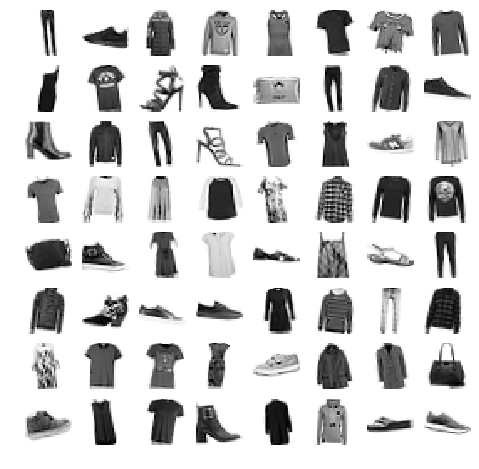

In [15]:
# Let's plot the first augmented examples
subplot_dims = (8,8)
index = 0

max_examples = subplot_dims[0]*subplot_dims[1]
for x_batch, y_batch in datagen_train.flow(X_train, y_train, batch_size=max_examples):
  plt.figure(figsize=(8,8))
  for index in range(max_examples):
    plt.subplot(subplot_dims[0], subplot_dims[1], index + 1)
    plot_image(x_batch[index, :,:,0])
  break

# Model

- An official benchmark is recorded for everything but neural network in sklearn [here](http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/). Best mean accuracy on test set: 0.897.
- Another benchmark including neural network is tracked [here](https://github.com/zalandoresearch/fashion-mnist/blob/master/README.md#benchmark). Best accuracy on test set: 0.967.

In [0]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization

num_classes = 10

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 kernel_initializer='he_normal',
                 input_shape=input_size))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

Let's train our network with early stopping.
We set the generated batch sizes for the validation and the training set to 

`(number of samples in set) / (batch_size)` 

To allow the model to train each sample at most once per epoch.

In [57]:
batch_size = 256
epochs = 150

train_step_per_epoch = len(X_train) / batch_size
val_step_per_epoch = len(X_val) / batch_size

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0.005,
                              patience=10,
                              mode='auto')

history = model.fit_generator(generator=datagen_train.flow(X_train, y_train, batch_size=batch_size),
                    epochs=epochs,
                    steps_per_epoch=train_step_per_epoch,
                    validation_data=datagen_val.flow(X_val, y_val, batch_size=batch_size),
                    validation_steps=val_step_per_epoch,
                    callbacks=[early_stopping],
                    initial_epoch=0,
                    workers=10, 
                    use_multiprocessing=True,
                    verbose=2)

Epoch 1/150

 - 17s - loss: 0.8558 - acc: 0.6855 - val_loss: 0.4891 - val_acc: 0.8208
Epoch 2/150
 - 16s - loss: 0.5448 - acc: 0.7982 - val_loss: 0.3877 - val_acc: 0.8573
Epoch 3/150
 - 16s - loss: 0.4640 - acc: 0.8286 - val_loss: 0.3490 - val_acc: 0.8785
Epoch 4/150
 - 16s - loss: 0.4187 - acc: 0.8451 - val_loss: 0.3270 - val_acc: 0.8828
Epoch 5/150
 - 16s - loss: 0.3878 - acc: 0.8595 - val_loss: 0.2841 - val_acc: 0.8948
Epoch 6/150
 - 16s - loss: 0.3719 - acc: 0.8641 - val_loss: 0.2819 - val_acc: 0.8965
Epoch 7/150
 - 16s - loss: 0.3587 - acc: 0.8680 - val_loss: 0.2668 - val_acc: 0.8988
Epoch 8/150
 - 16s - loss: 0.3408 - acc: 0.8768 - val_loss: 0.2608 - val_acc: 0.9080
Epoch 9/150
 - 16s - loss: 0.3336 - acc: 0.8788 - val_loss: 0.2455 - val_acc: 0.9115
Epoch 10/150
 - 16s - loss: 0.3231 - acc: 0.8833 - val_loss: 0.2398 - val_acc: 0.9160
Epoch 11/150
 - 16s - loss: 0.3155 - acc: 0.8854 - val_loss: 0.2427 - val_acc: 0.9113
Epoch 12/150
 - 16s - loss: 0.3101 - acc: 0.8872 - val_loss: 0

Epoch 35/150
 - 16s - loss: 0.2384 - acc: 0.9114 - val_loss: 0.1929 - val_acc: 0.9345
Epoch 36/150
 - 16s - loss: 0.2359 - acc: 0.9135 - val_loss: 0.1911 - val_acc: 0.9282
Epoch 37/150
 - 16s - loss: 0.2349 - acc: 0.9136 - val_loss: 0.1852 - val_acc: 0.9328
Epoch 38/150
 - 16s - loss: 0.2350 - acc: 0.9140 - val_loss: 0.1848 - val_acc: 0.9335
Epoch 39/150
 - 16s - loss: 0.2299 - acc: 0.9154 - val_loss: 0.1902 - val_acc: 0.9333
Epoch 40/150
 - 16s - loss: 0.2288 - acc: 0.9167 - val_loss: 0.1894 - val_acc: 0.9323
Epoch 41/150
 - 16s - loss: 0.2296 - acc: 0.9162 - val_loss: 0.1948 - val_acc: 0.9287
Epoch 42/150
 - 16s - loss: 0.2321 - acc: 0.9147 - val_loss: 0.1812 - val_acc: 0.9375
Epoch 43/150
 - 16s - loss: 0.2244 - acc: 0.9172 - val_loss: 0.1784 - val_acc: 0.9355
Epoch 44/150
 - 16s - loss: 0.2260 - acc: 0.9160 - val_loss: 0.1863 - val_acc: 0.9308
Epoch 45/150
 - 16s - loss: 0.2256 - acc: 0.9160 - val_loss: 0.1867 - val_acc: 0.9325
Epoch 46/150
 - 16s - loss: 0.2204 - acc: 0.9194 - val

Let's plot the accuracy and the validation accuracy together.

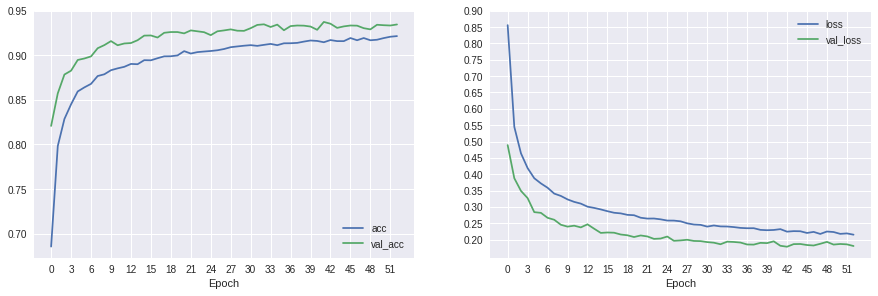

In [59]:
def plot_history(keras_history,
                 metrics=['acc'], 
                 plot_validation=True, 
                 figure_size=(15,10)):
  plt.figure(figsize=figure_size)
  
  for index, metric in enumerate(metrics):
    ax = plt.subplot(2, 2, index + 1)
    ax.plot(history.history[metric], label=metric)
    if(plot_validation):
      val = 'val_{0}'.format(metric)
      ax.plot(history.history[val], label=val)
    
    ax.legend(framealpha=0.8, fancybox=True)
   
    min_rounded_value = round(min(history.history[metric]), 1)
    max_sup_value =  max(history.history[metric])+0.05
    plt.yticks(np.arange(min_rounded_value, max_sup_value, step=0.05))
    
    max_epoch = len(history.history[metric])
    step = int(max_epoch/15) if (max_epoch > 30) else 2
    plt.xticks(np.arange(0, max_epoch, step=step))
    ax.set(xlabel='Epoch')
    
plot_history(keras_history=history, metrics=['acc', 'loss'])
stopped_at_epoch = len(history.history['acc'])

In [61]:
evaluations =  model.evaluate(x=X_val, y=y_val, batch_size=batch_size)
evaluations

6000/6000 [==============================] - 0s 46us/step


[2.597900094985962, 0.4935]

Let's have a look at the precision, recall and f1-score for each class. 

Reminder:

- Precision answer to the question "how many selected items are relevant ?"
- Recall answers to the question "how many relevant items are selected ?"

In [62]:
from sklearn.metrics import classification_report

y_pred_test = to_categorical(model.predict(X_test).argmax(axis=1))

print(classification_report(y_test, y_pred_test, target_names=classes))

             precision    recall  f1-score   support

T-shirt/top       0.78      0.08      0.14      1000
    Trouser       0.91      0.95      0.93      1000
   Pullover       0.60      0.58      0.59      1000
      Dress       0.99      0.32      0.49      1000
       Coat       0.29      0.96      0.44      1000
     Sandal       0.97      0.03      0.06      1000
      Shirt       0.29      0.09      0.14      1000
    Sneaker       0.88      0.62      0.73      1000
        Bag       0.34      0.84      0.48      1000
 Ankle boot       0.77      0.56      0.65      1000

avg / total       0.68      0.50      0.46     10000



We can see that T-shirt and Shirt are almost classifed as a random classifier.

This is probably because we tested our model on rotated/shifted images only and not on 'raw' datas.

Train on 54000 samples, validate on 6000 samples
Epoch 54/93
 - 24s - loss: 0.2819 - acc: 0.8988 - val_loss: 0.1997 - val_acc: 0.9305
Epoch 55/93
 - 25s - loss: 0.2333 - acc: 0.9153 - val_loss: 0.1944 - val_acc: 0.9305
Epoch 56/93
 - 24s - loss: 0.2179 - acc: 0.9208 - val_loss: 0.1983 - val_acc: 0.9275
Epoch 57/93
 - 25s - loss: 0.2092 - acc: 0.9215 - val_loss: 0.1835 - val_acc: 0.9337
Epoch 58/93
 - 25s - loss: 0.2015 - acc: 0.9250 - val_loss: 0.1820 - val_acc: 0.9345
Epoch 59/93
 - 24s - loss: 0.1978 - acc: 0.9277 - val_loss: 0.1823 - val_acc: 0.9342
Epoch 60/93
 - 24s - loss: 0.1939 - acc: 0.9281 - val_loss: 0.1880 - val_acc: 0.9332
Epoch 61/93
 - 24s - loss: 0.1866 - acc: 0.9300 - val_loss: 0.2061 - val_acc: 0.9298
Epoch 62/93
 - 24s - loss: 0.1824 - acc: 0.9326 - val_loss: 0.1838 - val_acc: 0.9377
Epoch 63/93
 - 24s - loss: 0.1768 - acc: 0.9341 - val_loss: 0.1851 - val_acc: 0.9392
Epoch 64/93
 - 25s - loss: 0.1759 - acc: 0.9354 - val_loss: 0.1825 - val_acc: 0.9385
Epoch 65/93
 - 2

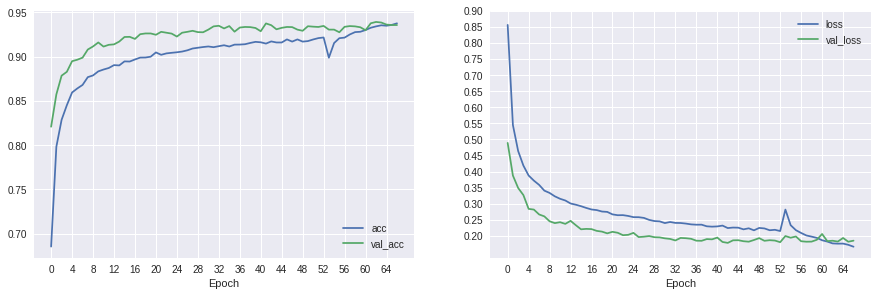

In [63]:
bonus_epoch = 40
history_sup = model.fit(X_train, y_train, 
                     initial_epoch=stopped_at_epoch, 
                     verbose=2,
                     callbacks=[early_stopping],
                     validation_data=(X_val, y_val),
                     epochs=stopped_at_epoch+bonus_epoch)

def concatenate_history(history, history2, metrics=['acc', 'loss'], validation=True):
  for metric in metrics:
    history.history[metric] = history.history[metric] + history_sup.history[metric]
    if(validation):
      history.history['val_'+metric] = history.history['val_'+metric] + history_sup.history['val_'+metric]
     
  return history

history = concatenate_history(history, history_sup)
plot_history(keras_history=history, metrics=['acc', 'loss'])

In [83]:
from sklearn.metrics import classification_report

y_pred_test = model.predict(X_test).argmax(axis=1)
y_pred_test_cat = to_categorical(y_pred_test)

print(classification_report(y_test, y_pred_test_cat, target_names=classes))

             precision    recall  f1-score   support

T-shirt/top       0.88      0.91      0.90      1000
    Trouser       0.99      0.99      0.99      1000
   Pullover       0.87      0.92      0.90      1000
      Dress       0.93      0.96      0.94      1000
       Coat       0.91      0.90      0.90      1000
     Sandal       1.00      0.97      0.98      1000
      Shirt       0.86      0.76      0.81      1000
    Sneaker       0.93      0.99      0.96      1000
        Bag       0.99      0.99      0.99      1000
 Ankle boot       0.99      0.95      0.97      1000

avg / total       0.93      0.93      0.93     10000



In [84]:
evaluations =  model.evaluate(x=X_val, y=y_val, batch_size=batch_size)
evaluations

6000/6000 [==============================] - 0s 51us/step


[0.18530255722999572, 0.9356666661898295]

An accuracy of 0.935 is not bad with a small network.

We can see from the correlation matrix that:

- 50 ankle boots were predited as a shirt
- 94 dresses prediced as a T-Shirt
- 69 dresses predicted as a pullover

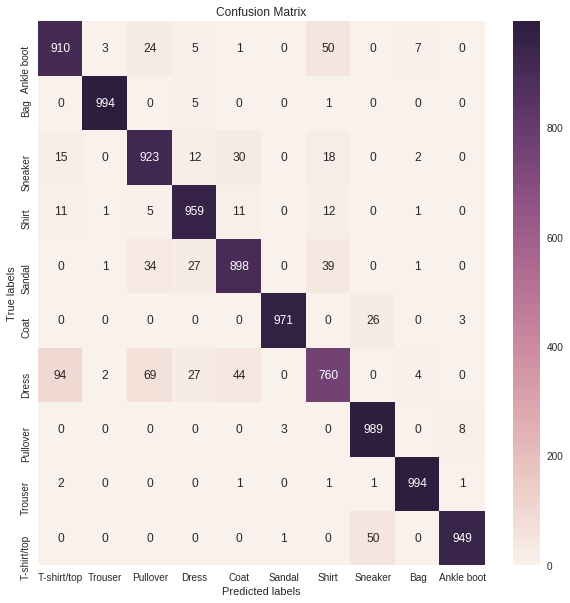

In [114]:
# seen on stackoverflow.com/a/48018785/3198863

from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test.argmax(axis=1), y_pred_test);

fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(cm, annot=True, ax = ax, fmt='g');

ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);